# Fraud Detection Using a Variational Autoencoder for Credit Card dataset

### Importing required libraries
- For ploting we use matplotlib and seaborn moduels
- For reading csv data, we use pandas
- For consturcting autoencoder, we use tensorflow and keras modules
- Sklearn Module for data processing

In [1]:
# import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras import regularizers


# Set Environment Variables
%matplotlib inline
RANDOM_SEED = 27
LABELS = ["Normal", "Fraud"]

2024-05-02 03:43:46.564325: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-02 03:43:46.603223: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-02 03:43:47.326934: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data Exploration & Data Preperation

It is shown in the previous file where we used neural autoencoder for fraud detection. So let us proceed.

In [2]:
df = pd.read_csv('creditcard.csv')
frauds = df[df.Class == 1]
normal = df[df.Class == 0]

# Time is irrelevant
df2 = df.drop(['Time'], axis=1)
# Standardize Amount
#df2['Amount'] = StandardScaler().fit_transform(df2['Amount'].values.reshape(-1, 1))
# split data
X_train, X_test = train_test_split(df2, test_size=0.2, random_state=RANDOM_SEED)
# Train on Normal (Class=0)
X_train = X_train[X_train.Class == 0]
# "Class" variable is not needed
X_train = X_train.drop(['Class'], axis=1)
# test data
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

# Standardize data based on mean & sd of X_train
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

# convert to numpy
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

## Building Model
- Our VAE uses two encoding layers, two decoding layers, and a latent layer
- Input layer has dimension of 30
- Encoder has two hidden layers with 20 and 15 neurons respectively
- Latent layer has 5 neurons
- Decoder has two hidden layers with 15 and 20 neurons respectively
- Output has again original dimension of 30

In the below we defined the parameters we use for this model. And also we train this model for 50 epochs with a batch size of 32

In [3]:
# defining the key parameters
batch_size = 100
original_dim = 29
latent_dim = 5
intermediate_dim1 = 20
intermediate_dim2 = 10
epochs = 50
epsilon_std = 1.0

### Sampler

This takes the z_mean and z_log_var that are computed at latent layer. This sampler is used to generate data points by sampling from latent space. This process involves drawing sample from a probability distribution specified by latent space.

Here we  Instead of directly sampling from the Gaussian distribution defined by μ and Σ, which would prevent the gradients from flowing through the sampling operation, the reparameterization trick involves introducing a new variable ϵ sampled from a fixed distribution.

In [4]:
# sampling from mean and sd in VAE
def sampling(args: tuple):
    # we grab the variables from the tuple
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

### Encoder

In [5]:
#########################
# input to our encoder
#########################
x = Input(shape=(original_dim,), name="input")
# intermediate layer
#h1 = Dense(intermediate_dim1, activation='tanh', name="encoding1")(x)
h1 = Dense(intermediate_dim1, activation="tanh", name="encoding1", activity_regularizer=regularizers.l1(10e-5))(x)
h = Dense(intermediate_dim2, activation='relu', name="encoding")(h1)
# defining the mean of the latent space
z_mean = Dense(latent_dim, name="mean")(h)
# defining the log variance of the latent space
z_log_var = Dense(latent_dim, name="log-variance")(h)
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
# defining the encoder as a keras model
encoder = Model(x, [z_mean, z_log_var, z], name="encoder")
# print out summary of what we just did
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 29)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoding1 (Dense)   │ (None, 20)        │        600 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoding (Dense)    │ (None, 10)        │        210 │ encoding1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mean (Dense)        │ (None, 5)         │         55 │ encoding[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ log-variance        │ (None, 5)         │         55 │ encoding[0][0]    │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 5)         │          0 │ mean[0][0],       │
│                     │                   │            │ log-variance[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 920 (3.59 KB)

 Trainable params: 920 (3.59 KB)

 Non-trainable params: 0 (0.00 B)

### Decoder

In [6]:
#########################
# Input to the decoder
#########################
input_decoder = Input(shape=(latent_dim,), name="decoder_input")
# taking the latent space to intermediate dimension
decoder_h1 = Dense(intermediate_dim2, activation='relu', name="decoder_h2")(input_decoder)
decoder_h = Dense(intermediate_dim1, activation='relu', name="decoder_h")(decoder_h1)
# getting the mean from the original dimension
x_decoded = Dense(original_dim, activation='tanh', name="flat_decoded")(decoder_h)
# defining the decoder as a keras model
decoder = Model(input_decoder, x_decoded, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_h2 (Dense)              │ (None, 10)             │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_h (Dense)               │ (None, 20)             │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flat_decoded (Dense)            │ (None, 29)             │           609 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 889 (3.47 KB)

 Trainable params: 889 (3.47 KB)

 Non-trainable params: 0 (0.00 B)

### Model

In [7]:
##########################
# Variational Autoencoder
##########################
# grab the output. Recall, that we need to grab the 3rd element our sampling z
output_combined = decoder(encoder(x)[2])
# link the input and the overall output
vae = Model(x, output_combined)
# print out what the overall model looks like
vae.summary()
# Defina VAE Loss Function
def vae_loss_(x: tf.Tensor, x_decoded_mean: tf.Tensor,z_log_var=z_log_var, z_mean=z_mean, original_dim=original_dim):
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    #kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    #vae_loss = K.mean(xent_loss + kl_loss)
    return xent_loss

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 29)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ [(None, 5), (None, 5), │           920 │
│                                 │ (None, 5)]             │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 29)             │           889 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,809 (7.07 KB)

 Trainable params: 1,809 (7.07 KB)

 Non-trainable params: 0 (0.00 B)

### Loss Function

The loss function consists of two main components
1. Reconstruction Loss
2. KL Divergence Loss

   #### Reconstruction Loss
   - It measure how well the VAE can reconstruct the input data x from the latent representation z.
   - The metrix.binary_crossentropy function calculate binary cross entropy loss between the original input data and the decoded one
   - We used this binary_crossentropy loss as reconstruction loss
   #### KL Divergence Loss
   - The KL divergence loss measures the dissimilarity between the distribution of the latent space representations and a chosen prior distribution, typically a standard normal distribution
   - The KL divergence loss is computed based on the mean (z_mean) and log-variance (z_log_var) of the latent space representations.

In [8]:
# Defina VAE Loss Function
def vae_loss(x: tf.Tensor, x_decoded_mean: tf.Tensor,z_log_var=z_log_var, z_mean=z_mean, original_dim=original_dim):
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)
    return vae_loss

### Compile and train the VAE

In [9]:
# Compile VAE model with custom loss function
vae.compile(optimizer='adam', loss=vae_loss_, metrics=['accuracy'])

# Train the model
history = vae.fit(X_train, X_train,
                  epochs=epochs,
                  batch_size=batch_size,
                  shuffle=True,
                  validation_data=(X_test, X_test),
                  verbose=1).history

Epoch 1/50
2275/2275 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.0646 - loss: -2.2165 - val_accuracy: 0.0838 - val_loss: -10.9541
Epoch 2/50
2275/2275 ━━━━━━━━━━━━━━━━━━━━ 2s 979us/step - accuracy: 0.0914 - loss: -13.1808 - val_accuracy: 0.0865 - val_loss: -19.0906
Epoch 3/50
2275/2275 ━━━━━━━━━━━━━━━━━━━━ 2s 962us/step - accuracy: 0.0954 - loss: -18.9599 - val_accuracy: 0.0962 - val_loss: -23.1677
Epoch 4/50
2275/2275 ━━━━━━━━━━━━━━━━━━━━ 2s 968us/step - accuracy: 0.1017 - loss: -23.0915 - val_accuracy: 0.1084 - val_loss: -27.4922
Epoch 5/50
2275/2275 ━━━━━━━━━━━━━━━━━━━━ 2s 970us/step - accuracy: 0.1111 - loss: -28.6674 - val_accuracy: 0.1160 - val_loss: -33.7039
Epoch 6/50
2275/2275 ━━━━━━━━━━━━━━━━━━━━ 2s 917us/step - accuracy: 0.1157 - loss: -34.1853 - val_accuracy: 0.1032 - val_loss: -35.2838
Epoch 7/50
2275/2275 ━━━━━━━━━━━━━━━━━━━━ 2s 914us/step - accuracy: 0.1107 - loss: -36.9624 - val_accuracy: 0.1229 - val_loss: -41.6809
Epoch 8/50
2275/2275 ━━━━━━━━━━━━━━━━━━━━ 2s 928us/

## Evaluation

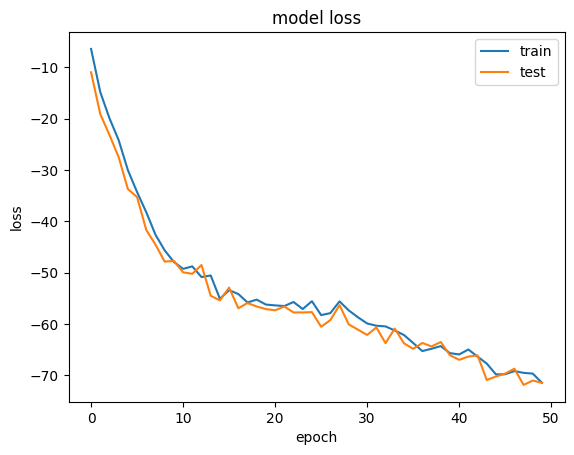

In [10]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [11]:
predictions = vae.predict(X_test)
mse = np.mean(np.power(X_test - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': y_test})
error_df.describe()

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 606us/step


,reconstruction_error,true_class
count,56962.000000,56962.000000
mean,1.041138,0.001826
std,4.097769,0.042690
min,0.137453,0.000000
25%,0.469001,0.000000
50%,0.644611,0.000000
75%,0.906212,0.000000
max,466.198647,1.000000


In [12]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc, accuracy_score, precision_score,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

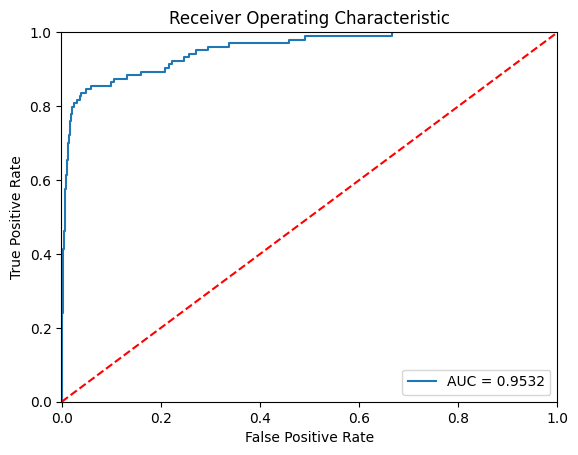

In [13]:
fpr, tpr, thresholds = roc_curve(error_df.true_class, error_df.reconstruction_error)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

Precision = True Positives/(True Positives + False Positives)

Precision measures the relevancy of obtained results. Recall, on the other hand, measures how many relevant results are returned. 

Recall = True positive/(True Positive + False Negatives)

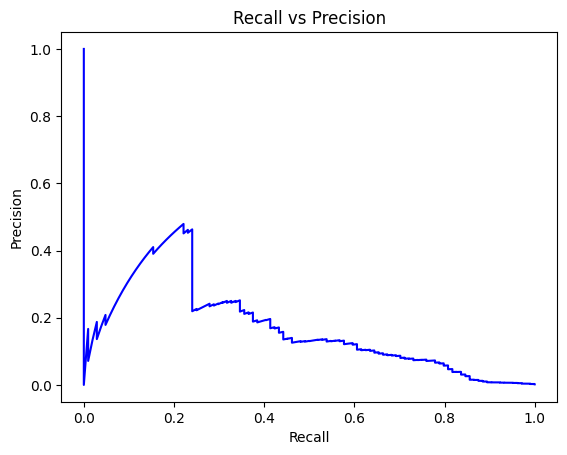

In [14]:

precision, recall, th = precision_recall_curve(error_df.true_class, error_df.reconstruction_error)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

A high area under the curve represents both high recall and high precision, where high precision relates to a low false positive rate, and high recall relates to a low false negative rate. High scores for both show that the classifier is returning accurate results (high precision), as well as returning a majority of all positive results (high recall)

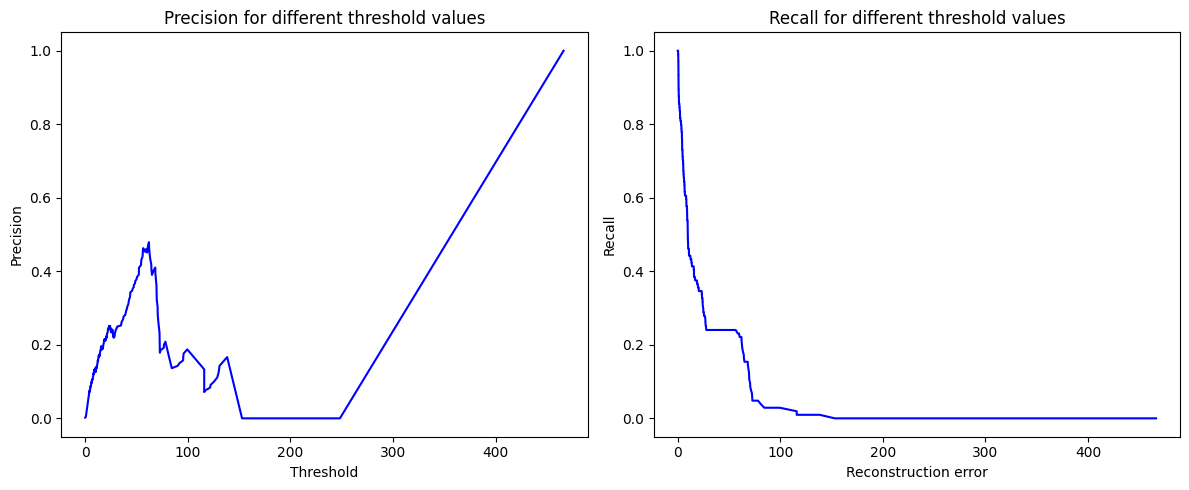

In [15]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot precision
axs[0].plot(th, precision[1:], 'b', label='Threshold-Precision curve')
axs[0].set_title('Precision for different threshold values')
axs[0].set_xlabel('Threshold')
axs[0].set_ylabel('Precision')

# Plot recall
axs[1].plot(th, recall[1:], 'b', label='Threshold-Recall curve')
axs[1].set_title('Recall for different threshold values')
axs[1].set_xlabel('Reconstruction error')
axs[1].set_ylabel('Recall')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plots
plt.show()

From above graphs, we can see that reconstruction error is increasing with precision and decreasing with recall

In [16]:
threshold = 2.9
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]

# Compute accuracy
accuracy = accuracy_score(error_df.true_class, y_pred)

# Compute precision, recall, and F1 score
precision = precision_score(error_df.true_class, y_pred)
recall = recall_score(error_df.true_class, y_pred)
f1 = f1_score(error_df.true_class, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.9709982093325374
Precision: 0.04895104895104895
Recall: 0.8076923076923077
F1 Score: 0.0923076923076923


The above are the accuray , precision score, recall score and F1 score respectively
- Accuracy measures the overall correctness of the predictions.
- Precision measures the proportion of true positive predictions among all positive predictions.
- Recall measures the proportion of true positive predictions among all actual positives.
- F1 Score is the harmonic mean of precision and recall, providing a balance between the two metrics.

Hence we see that our model has 97% accuracy, and Our model has Good recall but somewhat bad precision. That is amont all positive predictions, we are giving false positives.

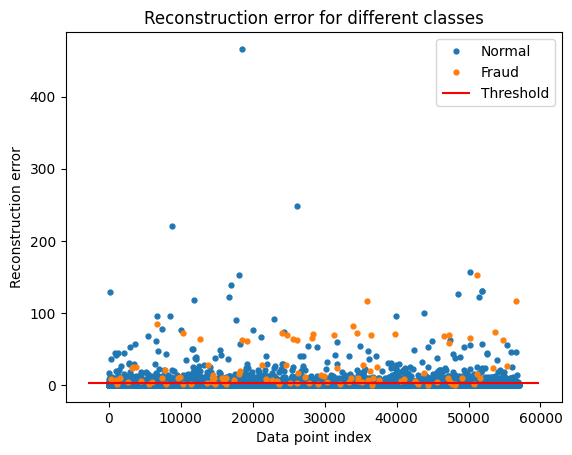

In [17]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

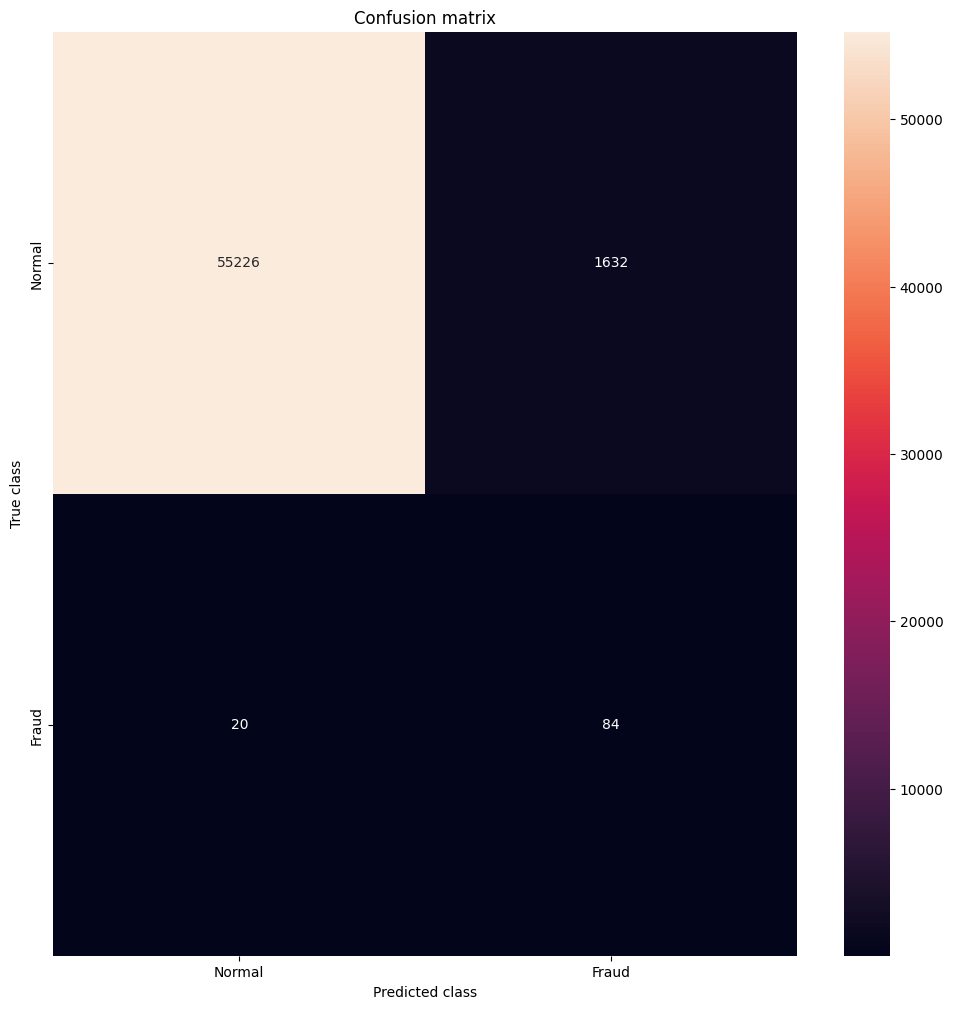

In [18]:
conf_matrix = confusion_matrix(error_df.true_class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()